BERT, Classfication layer

In [1]:
name = "bert_undersampled"

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


train_data = pd.read_csv('../datasets/data_train.csv')
test_data = pd.read_csv('../datasets/data_test.csv')
valid_data = pd.read_csv('../datasets/data_valid.csv')

all_labels = pd.concat([train_data["label"], test_data["label"], valid_data["label"]])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

LabelEncoder()

In [3]:
def extract_texts_labels(data, label_encoder):
    texts = data['data'].values
    labels = data['label'].values
    encoded_labels = label_encoder.transform(labels)
    return texts, encoded_labels

In [4]:
from sklearn.utils import shuffle
import pandas as pd

# Assuming train_data is already defined
df = train_data.copy()

print("Original Class Distribution:")
print(df['label'].value_counts())

# Specify the classes to be undersampled
undersample_labels = ['other-minor', 'meniscus-urgent', 'cruciate-ligament-urgent', "meniscus-minor"]

# Calculate the number of samples needed to match the least populous class
class_counts = df['label'].value_counts()
minority_class_count = class_counts.min()

# Initialize an empty dataframe to collect undersampled data
undersampled_dfs = [df[~df['label'].isin(undersample_labels)]]  # Exclude classes to be undersampled

for label in undersample_labels:
    majority_df = df[df['label'] == label]
    frac = minority_class_count/len(majority_df)
    undersampled_majority_df = majority_df.sample(frac=frac, random_state=42)
    undersampled_dfs.append(undersampled_majority_df)

# Combine the original dataframe with the undersampled majority dataframes
balanced_df = pd.concat(undersampled_dfs, ignore_index=True)

# Shuffle the dataset
train_data = shuffle(balanced_df, random_state=42)

print("New Class Distribution After Shuffling:")
print(balanced_df['label'].value_counts())


Original Class Distribution:
label
other-minor                 9805
meniscus-urgent             9312
cruciate-ligament-urgent    2388
meniscus-minor              1664
cruciate-ligament-minor      355
Name: count, dtype: int64
New Class Distribution After Shuffling:
label
cruciate-ligament-minor     355
other-minor                 355
meniscus-urgent             355
cruciate-ligament-urgent    355
meniscus-minor              355
Name: count, dtype: int64


In [5]:
train_texts, train_labels = extract_texts_labels(train_data, label_encoder)
test_texts, test_labels = extract_texts_labels(test_data, label_encoder)
valid_texts, valid_labels = extract_texts_labels(valid_data, label_encoder)


In [6]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-german-cased')

# Tokenize the data
train_encodings = tokenizer(train_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)
test_encodings = tokenizer(test_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)
valid_encodings = tokenizer(valid_texts.astype(str).tolist(), truncation=True, padding='max_length', max_length=400)

In [7]:
import tensorflow as tf

def create_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    return dataset

train_dataset = create_dataset(train_encodings, train_labels)
test_dataset = create_dataset(test_encodings, test_labels)
valid_dataset = create_dataset(valid_encodings, valid_labels)

2024-08-02 22:59:33.616350: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-08-02 22:59:33.616391: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-08-02 22:59:33.616398: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-08-02 22:59:33.616422: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-02 22:59:33.616439: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
from transformers import TFBertForSequenceClassification

# Load the BERT model for sequence classification with the number of output labels
model = TFBertForSequenceClassification.from_pretrained('google-bert/bert-base-german-cased', num_labels=len(label_encoder.classes_))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[ "accuracy" ]
)


In [10]:
# Train the model with early stopping callback
model.fit(train_dataset.shuffle(1000).batch(64),
          validation_data=valid_dataset.batch(64),
          epochs=3)


Epoch 1/3


2024-08-02 23:00:01.876997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 684s 24s/step - loss: 1.6132 - accuracy: 0.2118 - val_loss: 1.5067 - val_accuracy: 0.3425
Epoch 2/3
28/28 [==============================] - 636s 23s/step - loss: 1.5331 - accuracy: 0.3177 - val_loss: 1.4793 - val_accuracy: 0.3495
Epoch 3/3
28/28 [==============================] - 640s 23s/step - loss: 1.4286 - accuracy: 0.3825 - val_loss: 1.4880 - val_accuracy: 0.3128


In [11]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset.batch(32))
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

246/246 [==============================] - 382s 2s/step - loss: 1.4826 - accuracy: 0.3132
Loss: 1.482598066329956
Accuracy: 0.3131854236125946


In [12]:
model.save_pretrained(name)
tokenizer.save_pretrained(name + "_tokenizer")

('bert_undersampled_tokenizer/tokenizer_config.json',
 'bert_undersampled_tokenizer/special_tokens_map.json',
 'bert_undersampled_tokenizer/vocab.txt',
 'bert_undersampled_tokenizer/added_tokens.json')

In [13]:
import numpy as np
predictions = model.predict(test_dataset.batch(32))
predicted_labels = np.argmax(predictions.logits, axis=-1)

# Decode class labels to original labels
decoded_predictions = label_encoder.inverse_transform(predicted_labels)

# True labels from the test set
true_labels = label_encoder.inverse_transform(test_labels)

# Create a DataFrame to compare
comparison_df = pd.DataFrame({'Text': test_texts, 'True Label': true_labels, 'Predicted Label': decoded_predictions})

246/246 [==============================] - 392s 2s/step


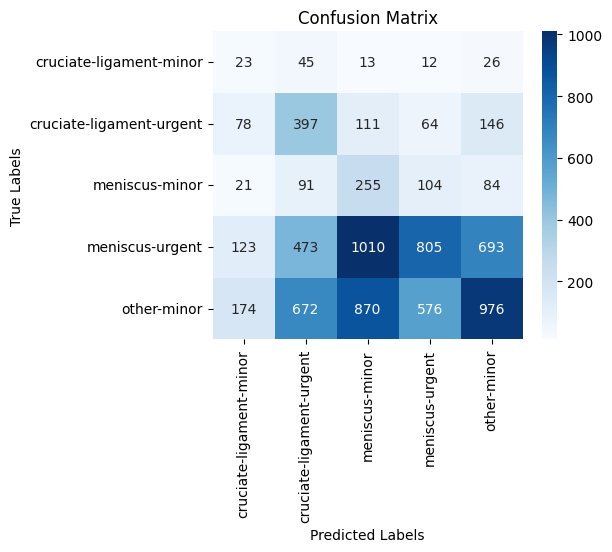

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(true_labels, decoded_predictions, labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [15]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

 cruciate-ligament-minor       0.05      0.19      0.09       119
cruciate-ligament-urgent       0.24      0.50      0.32       796
          meniscus-minor       0.11      0.46      0.18       555
         meniscus-urgent       0.52      0.26      0.35      3104
             other-minor       0.51      0.30      0.38      3268

                accuracy                           0.31      7842
               macro avg       0.29      0.34      0.26      7842
            weighted avg       0.45      0.31      0.34      7842



In [16]:
from sklearn.metrics import classification_report
report = classification_report(true_labels, decoded_predictions, target_names=label_encoder.classes_, output_dict=True)

In [17]:
df = pd.DataFrame(report).transpose()
df.to_csv(name + "_report.csv")

: 